In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from gtfparse import read_gtf
import bioframe
import warnings
warnings.filterwarnings('ignore')

### Read ZFP143 peaks

In [6]:
peaks = pd.read_csv('./peaks/ZFP143_peaks.bed', sep = '\t', header = None)
peaks = peaks[[0, 1, 2, 3, 4, 5]]
peaks.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand']
peaks.head()

,chrom,start,end,name,score,strand
0,chr1,6214371,6214934,ZFP143_peak_12,1114,.
1,chr1,7397415,7397920,ZFP143_peak_13,2210,.
2,chr1,9544949,9545462,ZFP143_peak_14,755,.
3,chr1,9700257,9700814,ZFP143_peak_15,418,.
4,chr1,9747919,9748904,ZFP143_peak_16,3025,.


## Intersect peaks with motifs

SBS1 - short motif, SBS2 - long motif (with ACTACA)

### Read ZFP143 motifs

In [7]:
motifs_sbs1 = pd.read_csv('./annotations/ZFP143_SBS1_denovo_motifs.mm10.bed', sep = '\t', header = None)
motifs_sbs1.columns = ['chrom', 'start', 'end', 'name', 'strand', 'score']
motifs_sbs1 = motifs_sbs1[['chrom', 'start', 'end', 'name', 'score', 'strand']]
motifs_sbs1.head()

,chrom,start,end,name,score,strand
0,chr1,3010024,3010043,20,9.949885,+
1,chr1,3014481,3014500,20,9.586277,+
2,chr1,3015713,3015732,20,9.793811,-
3,chr1,3020931,3020950,20,10.677432,+
4,chr1,3026298,3026317,20,9.759503,-


In [8]:
motifs_sbs2 = pd.read_csv('./annotations/ZFP143_SBS2_denovo_motifs.mm10.bed', sep = '\t', header = None)
motifs_sbs2.columns = ['chrom', 'start', 'end', 'name', 'strand', 'score']
motifs_sbs2 = motifs_sbs2[['chrom', 'start', 'end', 'name', 'score', 'strand']]
motifs_sbs2.head()

,chrom,start,end,name,score,strand
0,chr1,3000162,3000182,21,12.540969,-
1,chr1,3019452,3019472,21,11.914875,-
2,chr1,3033295,3033315,21,12.630071,-
3,chr1,3046076,3046096,21,12.357994,-
4,chr1,3050858,3050878,21,13.138423,-


### Overlap with motifs

In [10]:
peaks_overlap_sbs1 = bioframe.overlap(peaks, motifs_sbs1, suffixes=('', '_sbs1')).dropna()
peaks_overlap_sbs2 = bioframe.overlap(peaks, motifs_sbs2, suffixes=('', '_sbs2')).dropna()
peaks_with_sbs1 = list(np.unique(peaks_overlap_sbs1['name']))
peaks_with_sbs2 = list(np.unique(peaks_overlap_sbs2['name']))
peaks_with_sbs1_and_sbs2 = list(set.intersection(set(peaks_with_sbs1), set(peaks_with_sbs2)))
peaks_only_sbs1 = [x for x in peaks_with_sbs1 if x not in peaks_with_sbs2]
peaks_only_sbs2 = [x for x in peaks_with_sbs2 if x not in peaks_with_sbs1]

peaks_overlap_sbs1_sbs2 = bioframe.overlap(bioframe.overlap(peaks, motifs_sbs1, suffixes=('', '_sbs1')), motifs_sbs2, suffixes=('', '_sbs2'))
peaks_with_overlapping_sbs1_and_sbs2 = []
for peak in peaks_with_sbs1_and_sbs2:
    peak_motif_pairs = peaks_overlap_sbs1_sbs2[peaks_overlap_sbs1_sbs2['name'] == peak]
    for pair in peak_motif_pairs.values:
        start_sbs1, end_sbs1, start_sbs2, end_sbs2 = pair[7], pair[8], pair[13], pair[14]
        if max(start_sbs1, start_sbs2) <= min(end_sbs1, end_sbs2):
            peaks_with_overlapping_sbs1_and_sbs2.append(peak)
            break

print('SBS1 or SBS2:', len(np.unique(np.hstack((peaks_with_sbs1, peaks_with_sbs2)))) / len(peaks) * 100)
print('SBS1 and SBS2:', len(peaks_with_sbs1_and_sbs2) / len(peaks) * 100)
print('SBS1 and SBS2 (overlapping):', len(peaks_with_overlapping_sbs1_and_sbs2) / len(peaks) * 100)
print('SBS1 only:', len(peaks_only_sbs1) / len(np.unique(peaks['name'])) * 100)
print('SBS2 only:', len(peaks_only_sbs2) / len(np.unique(peaks['name'])) * 100)

SBS1 or SBS2: 95.29633113828785
SBS1 and SBS2: 48.07149576669802
SBS1 and SBS2 (overlapping): 44.87300094073377
SBS1 only: 44.46534963938539
SBS2 only: 2.759485732204453


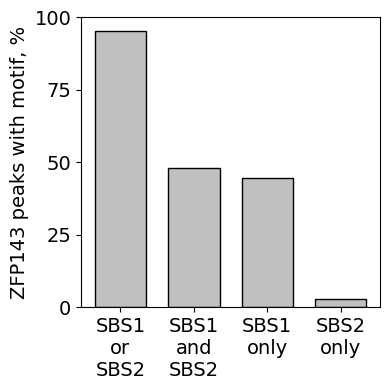

In [11]:
plt.figure(figsize = (4, 4))

plt.bar(x = [0, 1, 2, 3], height = [len(np.unique(np.hstack((peaks_with_sbs1, peaks_with_sbs2)))) / len(peaks) * 100,
                                    len(set.intersection(set(peaks_with_sbs1), set(peaks_with_sbs2))) / len(peaks) * 100,
                                    len([x for x in peaks_with_sbs1 if x not in peaks_with_sbs2]) / len(np.unique(peaks['name'])) * 100,
                                    len([x for x in peaks_with_sbs2 if x not in peaks_with_sbs1]) / len(np.unique(peaks['name'])) * 100],
        edgecolor = 'k', color = 'silver', width = 0.7)

plt.xticks([0, 1, 2, 3], ['SBS1\nor\nSBS2', 'SBS1\nand\nSBS2', 'SBS1\nonly', 'SBS2\nonly'], fontsize = 14)
plt.yticks([0, 25, 50, 75, 100], fontsize = 14)
plt.ylabel('ZFP143 peaks with motif, %', fontsize = 14)
plt.tight_layout()
plt.show()

## Assign ZFP143 target genes

In [20]:
# Read GTF with comprehensive gene annotation
genes = read_gtf('../gencode.vM25.annotation.gtf')

# Filter transcripts of protein coding or long non-coding RNAs with high confidence
genes = genes[genes['feature'] == 'transcript']
genes = genes[genes['transcript_support_level'].isin(['1', '2', '3', '4', '5'])]
genes = genes[genes['transcript_type'].isin(['protein_coding', 'lincRNA', 'processed_transcript', 'bidirectional_promoter_lncRNA', 'antisense'])]

genes = genes[['seqname', 'start', 'end', 'strand', 'gene_id', 'gene_name', 'gene_type', 'transcript_id', 'transcript_type', 'transcript_support_level']]
genes.head()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'mgi_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'protein_id', 'ccdsid', 'ont']


,seqname,start,end,strand,gene_id,gene_name,gene_type,transcript_id,transcript_type,transcript_support_level
7,chr1,3205901,3216344,-,ENSMUSG00000051951.5,Xkr4,protein_coding,ENSMUST00000162897.1,processed_transcript,1
10,chr1,3206523,3215632,-,ENSMUSG00000051951.5,Xkr4,protein_coding,ENSMUST00000159265.1,processed_transcript,1
13,chr1,3214482,3671498,-,ENSMUSG00000051951.5,Xkr4,protein_coding,ENSMUST00000070533.4,protein_coding,1
37,chr1,3466587,3513553,+,ENSMUSG00000089699.1,Gm1992,antisense,ENSMUST00000161581.1,antisense,3
63,chr1,3905739,3986215,-,ENSMUSG00000102343.1,Gm37381,lincRNA,ENSMUST00000194643.1,lincRNA,3


In [21]:
def get_tss(genes, margin_upstream, margin_downstream):
    genes_tss = []
    for gene in genes.values:
        if gene[3] == '+':
            genes_tss.append([gene[0], gene[1]-margin_upstream, gene[1]+margin_downstream, gene[4], gene[5], gene[3], gene[6], gene[7], gene[8], gene[9]])
        else:
            genes_tss.append([gene[0], gene[2]-margin_downstream, gene[2]+margin_upstream, gene[4], gene[5], gene[3], gene[6], gene[7], gene[8], gene[9]])

    genes_tss = pd.DataFrame(genes_tss)
    genes_tss.columns = ['chrom', 'start', 'end', 'gene_id', 'gene_name', 'strand', 'gene_type', 'transcript_id', 'transcript_type', 'transcript_support']
    return(genes_tss)

In [22]:
# Find overlap between peaks and TSS regions
peaks_overlap_genes = bioframe.overlap(peaks, get_tss(genes, 2000, 1000), suffixes=('', '_genes'))
peaks_overlap_genes = peaks_overlap_genes.drop(['score', 'strand', 'chrom_genes'], axis = 1).dropna()
peaks_overlap_genes['strand_genes'] = [str(x) for x in peaks_overlap_genes['strand_genes']]
peaks_overlap_genes.index = np.arange(len(peaks_overlap_genes))

In [23]:
# Replace transcript coordinates with actual coordinates instead of widened TSS coordinates
peaks_overlap_genes = peaks_overlap_genes.merge(genes, left_on = 'transcript_id_genes', right_on = 'transcript_id')
peaks_overlap_genes = peaks_overlap_genes.drop(['seqname', 'strand', 'gene_id', 'transcript_id', 
                                                'gene_name', 'gene_type', 'transcript_type', 'transcript_support_level'], axis = 1)
peaks_overlap_genes['start_genes'] = peaks_overlap_genes['start_y']
peaks_overlap_genes['end_genes'] = peaks_overlap_genes['end_y']
peaks_overlap_genes = peaks_overlap_genes.drop(['start_y', 'end_y'], axis = 1)
peaks_overlap_genes.columns = ['chrom', 'start_peak', 'end_peak', 'name_peak', 
                               'start_gene', 'end_gene', 'gene_id', 'gene_name', 'strand_gene', 'gene_type', 
                               'transcript_id', 'transcript_type', 'transcript_support']

In [24]:
# Add distance between transcript and center of the peak
distances = []
for peak_transcript_pair in peaks_overlap_genes.values:
    if peak_transcript_pair[8] == '+':
        distances.append(peak_transcript_pair[4] - (peak_transcript_pair[1]+peak_transcript_pair[2])//2)
    else:
        distances.append(peak_transcript_pair[5] - (peak_transcript_pair[1]+peak_transcript_pair[2])//2)
peaks_overlap_genes['distance'] = [abs(x) for x in distances]
peaks_overlap_genes = peaks_overlap_genes[peaks_overlap_genes['distance'] <= 2000]
peaks_overlap_genes.index = np.arange(len(peaks_overlap_genes))

In [25]:
# Remove lowly expressed genes and add expression values to the remaining transcripts
not_expressed_genes = pd.read_csv('../ttseq/degs/not_expressed.bed', sep = '\t')
peaks_overlap_genes = peaks_overlap_genes[~peaks_overlap_genes['gene_id'].isin(not_expressed_genes['gene_id'])]
peaks_overlap_genes.index = np.arange(len(peaks_overlap_genes))

expression = pd.read_csv('../ttseq/counts/counts_transcripts_analysis.txt', sep = '\t')
expression = expression[['transcript_id', 'start', 'end', 'Zfp143_DMSO_rep1', 'Zfp143_DMSO_rep2']]
expression['gene_length'] = (expression['end']-expression['start'])/1000
expression['rep1_rpkm'] = expression['Zfp143_DMSO_rep1'] / (np.sum(expression['Zfp143_DMSO_rep1'])/1000000) / expression['gene_length']
expression['rep2_rpkm'] = expression['Zfp143_DMSO_rep2'] / (np.sum(expression['Zfp143_DMSO_rep2'])/1000000) / expression['gene_length']
expression['rep1_cpm'] = expression['Zfp143_DMSO_rep1'] / (np.sum(expression['Zfp143_DMSO_rep1'])/1000000)
expression['rep2_cpm'] = expression['Zfp143_DMSO_rep2'] / (np.sum(expression['Zfp143_DMSO_rep2'])/1000000)
expression['rpkm'] = (expression['rep1_rpkm'] + expression['rep2_rpkm']) / 2
expression['cpm'] = (expression['rep1_cpm'] + expression['rep2_cpm']) / 2
expression = expression[['transcript_id', 'rpkm', 'cpm']]

peaks_overlap_genes = peaks_overlap_genes.merge(expression, on = 'transcript_id')

In [26]:
# For each gene find the transcript with highest (i) transcript support level, (ii) distance to peak, (iii) expression, (iv) length
indices_to_keep = []
for gene_id in np.unique(peaks_overlap_genes['gene_id']):
    overlaps_gene = peaks_overlap_genes[peaks_overlap_genes['gene_id'] == gene_id]
    overlaps_gene['length'] = overlaps_gene['end_gene']-overlaps_gene['start_gene']
    if len(overlaps_gene) == 1:
        indices_to_keep.append(overlaps_gene.index[0])
    else:
        ranked_transcripts = overlaps_gene.sort_values(['transcript_support', 'distance', 'cpm', 'length'], ascending = [1, 1, 0, 0])
        indices_to_keep.append(ranked_transcripts.index[0])

peaks_overlap_genes = peaks_overlap_genes.iloc[np.sort(indices_to_keep)]
peaks_overlap_genes.index = np.arange(len(peaks_overlap_genes))

In [27]:
# For peaks that were associated with multiple genes on same strand, try to find more appropriate one based on
# (i) transcript type, (ii) transcript support level and (iii) presence of genes with lower confidence at the same location
indices_to_remove = []
for peak in np.unique(peaks_overlap_genes['name_peak']):
    peak_genes = peaks_overlap_genes[peaks_overlap_genes['name_peak'] == peak]
    
    if (len(peak_genes[peak_genes['strand_gene'] == '+']) > 1) or (len(peak_genes[peak_genes['strand_gene'] == '-']) > 1):
        if (len(peak_genes[peak_genes['strand_gene'] == '+']) > 1):
            ambiguous_pairs = peak_genes[peak_genes['strand_gene'] == '+'][['gene_name', 'chrom', 'start_gene', 'end_gene', 'strand_gene', 'transcript_type', 'transcript_support', 'distance', 'rpkm', 'cpm']]
        else:
            ambiguous_pairs = peak_genes[peak_genes['strand_gene'] == '-'][['gene_name', 'chrom', 'start_gene', 'end_gene', 'strand_gene', 'transcript_type', 'transcript_support', 'distance', 'rpkm', 'cpm']]
        
        ambiguous_indices = ambiguous_pairs.index

        if len(ambiguous_pairs[ambiguous_pairs['transcript_type'].isin(['protein_coding', 'lincRNA'])]) > 0 and len(ambiguous_pairs) > 1:
            ambiguous_pairs = ambiguous_pairs[ambiguous_pairs['transcript_type'].isin(['protein_coding', 'lincRNA'])]
        if len(ambiguous_pairs[ambiguous_pairs['transcript_support'].isin(['1', '2'])]) > 0 and len(ambiguous_pairs) > 1:
            ambiguous_pairs = ambiguous_pairs[ambiguous_pairs['transcript_support'].isin(['1', '2'])]
        if len(['Gm' in x for x in ambiguous_pairs['gene_name'].values]) > 0 and len(['Gm' not in x for x in ambiguous_pairs['gene_name'].values]) > 0 and len(ambiguous_pairs) > 1:
            ambiguous_pairs = ambiguous_pairs[~ambiguous_pairs['gene_name'].isin([x for x in ambiguous_pairs['gene_name'].values if 'Gm' in x])]
            
        ambiguous_indices = [x for x in ambiguous_indices if x not in ambiguous_pairs.index]
        indices_to_remove = indices_to_remove + ambiguous_indices

peaks_overlap_genes = peaks_overlap_genes.drop(indices_to_remove)
peaks_overlap_genes.index = np.arange(len(peaks_overlap_genes))

In [28]:
# Add information about SBS1 or SBS2 motif presense in the peak
has_sbs1_motif_same_orientation, has_sbs2_motif_same_orientation = [], []
for peak_gene_pair in peaks_overlap_genes.values:
    motifs_associated_with_peak = peaks_overlap_sbs1_sbs2[peaks_overlap_sbs1_sbs2['name'] == peak_gene_pair[3]]
    
    gene_strand = peak_gene_pair[8]
    if gene_strand in motifs_associated_with_peak['strand_sbs1'].values:
        has_sbs1_motif_same_orientation.append(1)
    else:
        has_sbs1_motif_same_orientation.append(0)
        
    if gene_strand in motifs_associated_with_peak['strand_sbs2'].values:
        has_sbs2_motif_same_orientation.append(1)
    else:
        has_sbs2_motif_same_orientation.append(0)
        
peaks_overlap_genes['sbs1_motif'] = has_sbs1_motif_same_orientation
peaks_overlap_genes['sbs2_motif'] = has_sbs2_motif_same_orientation
peaks_overlap_genes['sbs1_and_sbs2_motif'] = [1 if x+y==2 else 0 for (x, y) in zip(peaks_overlap_genes['sbs1_motif'], peaks_overlap_genes['sbs2_motif'])]

In [29]:
peaks_overlap_genes.to_csv('./annotations/ZFP143_peaks_GENCODE_genes_associations.txt', sep = '\t', header = 1, index = 0)
peaks_overlap_genes['gene_id'].to_csv('./annotations/ZFP143_target_genes.ensembl_id.txt', header = 0, index = 0)
peaks_overlap_genes['gene_name'].to_csv('./annotations/ZFP143_target_genes.gene_name.txt', header = 0, index = 0)

## Statistics for ZFP143 target genes

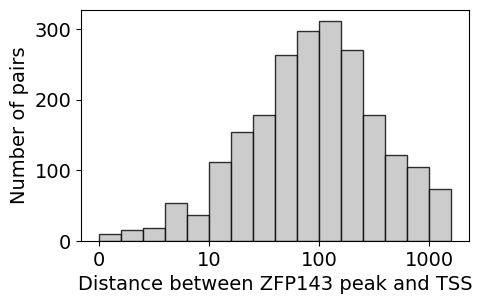

In [30]:
plt.figure(figsize = (5, 3))
plt.hist(np.log10(peaks_overlap_genes['distance']+1), range = (0, 3.2), bins = 16,
         edgecolor = 'k', alpha = 0.8, color = 'silver')
plt.xticks([0, 1, 2, 3], [0, 10, 100, 1000], fontsize = 14)
plt.yticks([0, 100, 200, 300], fontsize = 14)
plt.xlabel('Distance between ZFP143 peak and TSS', fontsize = 14)
plt.ylabel('Number of pairs', fontsize = 14)
plt.show()

In [31]:
print('Number of peaks associated:', len(np.unique(peaks_overlap_genes['name_peak'])), 
      '(' + str(round(len(np.unique(peaks_overlap_genes['name_peak']))/len(peaks)*100, 1)) + '% of peaks)')

unidirectional, bidirectional = 0, 0

for peak in np.unique(peaks_overlap_genes['name_peak']):
    peak_genes = peaks_overlap_genes[peaks_overlap_genes['name_peak'] == peak]
    if '+' in peak_genes['strand_gene'].values and '-' in peak_genes['strand_gene'].values:
        bidirectional += 1
    else:
        unidirectional += 1

print('Peaks associated with unidirectional promoters:', unidirectional,
      '(' + str(round(unidirectional/len(np.unique(peaks_overlap_genes['name_peak']))*100, 2)) + '%)')
print('Peaks associated with bidirectional promoters:', bidirectional, 
      '(' + str(round(bidirectional/len(np.unique(peaks_overlap_genes['name_peak']))*100, 2)) + '%)')

Number of peaks associated: 1846 (57.9% of peaks)
Peaks associated with unidirectional promoters: 1471 (79.69%)
Peaks associated with bidirectional promoters: 375 (20.31%)


In [32]:
print('Number of genes associated:', len(np.unique(peaks_overlap_genes['gene_id'])))

gene_types_associated = pd.DataFrame(np.unique(peaks_overlap_genes['transcript_type'], return_counts = 1))
gene_types_associated = gene_types_associated.transpose().sort_values([1], ascending = 0)
gene_types_associated[2] = gene_types_associated[1] / np.sum(gene_types_associated[1])
gene_types_associated.columns = ['transcript_type', 'number_of_transcripts', 'fraction']
gene_types_associated

Number of genes associated: 2226


,transcript_type,number_of_transcripts,fraction
4,protein_coding,1975,0.887242
3,processed_transcript,120,0.053908
0,antisense,71,0.031896
2,lincRNA,53,0.02381
1,bidirectional_promoter_lncRNA,7,0.003145


## ZFP143 target genes GO enrichment

In [36]:
go_enrichment = pd.read_csv('./annotations/gProfiler_mmusculus_04-10-2023_16-33-35__intersections.csv')
go_enrichment['fraction'] = go_enrichment['intersection_size'] / go_enrichment['term_size']
go_enrichment.head()

,source,term_name,term_id,highlighted,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections,fraction
0,GO:MF,nucleic acid binding,GO:0003676,True,6.849951e-40,39.164313,2657,1860,431,21671,"ENSMUSG00000043716,ENSMUSG00000041859,ENSMUSG0...",0.162213
1,GO:MF,binding,GO:0005488,False,1.269874e-33,32.896239,11555,1860,1248,21671,"ENSMUSG00000025907,ENSMUSG00000043716,ENSMUSG0...",0.108005
2,GO:MF,heterocyclic compound binding,GO:1901363,False,3.823687e-33,32.417518,3476,1860,500,21671,"ENSMUSG00000043716,ENSMUSG00000041859,ENSMUSG0...",0.143843
3,GO:MF,organic cyclic compound binding,GO:0097159,False,3.015522e-31,30.520637,3556,1860,502,21671,"ENSMUSG00000043716,ENSMUSG00000041859,ENSMUSG0...",0.141170
4,GO:MF,RNA binding,GO:0003723,False,1.554022e-22,21.808543,909,1860,175,21671,"ENSMUSG00000043716,ENSMUSG00000037447,ENSMUSG0...",0.192519


In [37]:
terms_to_plot = ['snRNA transcription by RNA polymerase II',
                 'transcription by RNA polymerase II',
                 'snRNA transcription by RNA polymerase III',
                 'transcription by RNA polymerase III',
                 'mitotic cell cycle',
                 'stem cell population maintenance',
                 'cytoplasmic translation',
                 'mitochondrial translation',
                 'cytosolic ribosome',
                 'mitochondrial ribosome',
                 'polysomal ribosome',
                 'oxidative phosphorylation',
                 'respirasome',
                 'ATP biosynthetic process',
                 'inner mitochondrial membrane organization',
                 'mitochondrion distribution',
                 'mitochondrion morphogenesis',
                 'protein targeting to mitochondrion',
                 'intrinsic apoptotic signaling pathway',
                 'TORC1 signaling',
                 'cellular response to stress',
                 'cytoplasmic stress granule',
                 'response to endoplasmic reticulum stress',
                 'protein folding',
                 'chaperone-mediated protein folding']

go = go_enrichment[go_enrichment['term_name'].isin(terms_to_plot)].sort_values('intersection_size', ascending = 0)
go.sort_values(by = 'term_name', key=lambda column: column.map(lambda e: terms_to_plot.index(e)), inplace = True)
go

,source,term_name,term_id,highlighted,adjusted_p_value,negative_log10_of_adjusted_p_value,term_size,query_size,intersection_size,effective_domain_size,intersections,fraction
702,GO:BP,snRNA transcription by RNA polymerase II,GO:0042795,False,1.181838e-02,1.927442,15,1837,6,22193,"ENSMUSG00000021113,ENSMUSG00000034525,ENSMUSG0...",0.400000
225,GO:BP,transcription by RNA polymerase II,GO:0006366,False,9.495888e-16,15.022464,2227,1837,297,22193,"ENSMUSG00000079658,ENSMUSG00000042197,ENSMUSG0...",0.133363
822,GO:BP,snRNA transcription by RNA polymerase III,GO:0042796,False,2.939805e-02,1.531682,8,1837,4,22193,"ENSMUSG00000021113,ENSMUSG00000034525,ENSMUSG0...",0.500000
615,GO:BP,transcription by RNA polymerase III,GO:0006383,False,3.043843e-03,2.516578,38,1837,11,22193,"ENSMUSG00000019837,ENSMUSG00000025583,ENSMUSG0...",0.289474
227,GO:BP,mitotic cell cycle,GO:0000278,False,1.302054e-15,14.885371,820,1837,142,22193,"ENSMUSG00000041859,ENSMUSG00000009907,ENSMUSG0...",0.173171
466,GO:BP,stem cell population maintenance,GO:0019827,True,2.082843e-04,3.681343,193,1837,35,22193,"ENSMUSG00000000902,ENSMUSG00000020166,ENSMUSG0...",0.181347
235,GO:BP,cytoplasmic translation,GO:0002181,False,4.841359e-15,14.315033,138,1837,46,22193,"ENSMUSG00000043716,ENSMUSG00000073702,ENSMUSG0...",0.333333
280,GO:BP,mitochondrial translation,GO:0032543,False,1.628423e-10,9.788233,124,1837,37,22193,"ENSMUSG00000026709,ENSMUSG00000034932,ENSMUSG0...",0.298387
960,GO:CC,cytosolic ribosome,GO:0022626,False,5.825454e-10,9.234670,113,1825,34,21708,"ENSMUSG00000043716,ENSMUSG00000073702,ENSMUSG0...",0.300885
966,GO:CC,mitochondrial ribosome,GO:0005761,False,7.622597e-08,7.117897,85,1825,26,21708,"ENSMUSG00000034932,ENSMUSG00000062981,ENSMUSG0...",0.305882


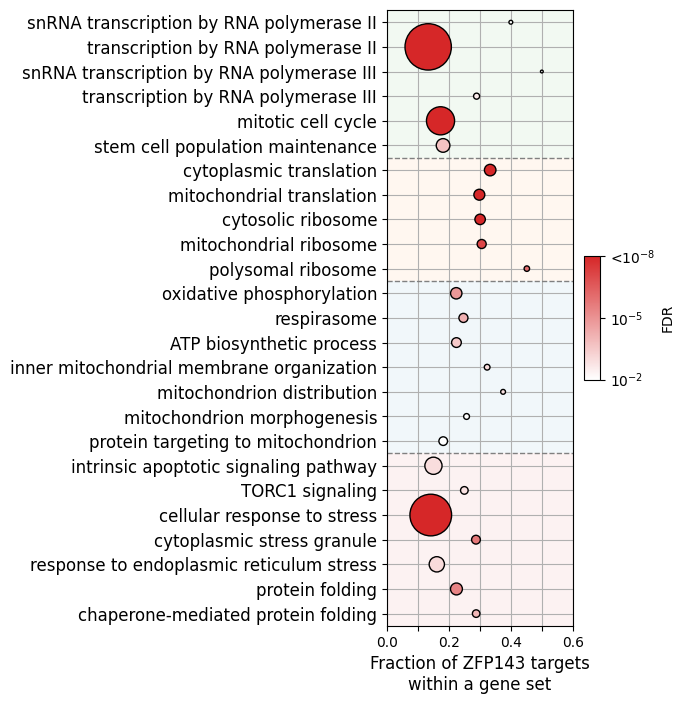

In [38]:
fraction = (go['intersection_size']/go['term_size']).values
number = go['term_size'].values
fdr = go['negative_log10_of_adjusted_p_value'].values

go_plot = pd.DataFrame({'Fraction': fraction, 'Position': -np.arange(len(fraction)), 'Colors': fdr, 'Size': number/2})

plt.figure(figsize = (3, 8))
plt.grid(zorder = 0)
plt.scatter('Fraction', 'Position', s = 'Size', c = 'Colors', data = go_plot, zorder = 3, edgecolor = 'k',
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "C3"]), vmin = 2, vmax = 8)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], ['0.0', '', '0.2', '', '0.4', '', '0.6'])
plt.xlim((0, 0.6))
plt.ylim((-24.5, 0.5))
plt.xlabel('Fraction of ZFP143 targets\nwithin a gene set', fontsize = 12)
#plt.yticks((-1)*np.arange(len(go)), [x + ' (' + str(y) + ')' for (x, y) in zip(go['term_name'], go['term_size'])], fontsize = 12)
plt.yticks((-1)*np.arange(len(go)), go['term_name'], fontsize = 12)
cbar = plt.colorbar(shrink = 0.2, ticks = [2, 5, 8], aspect = 8, label = 'FDR')
cbar.ax.set_yticklabels([r'$10^{-2}$', r'$10^{-5}$', r'<$10^{-8}$'])


plt.axhspan(-5.5, 0.5, facecolor = 'C2', alpha = 0.06)
plt.axhspan(-10.5, -5.5, facecolor = 'C1', alpha = 0.06)
plt.axhspan(-17.5, -10.5, facecolor = 'C0', alpha = 0.06)
plt.axhspan(-24.5, -17.5, facecolor = 'C3', alpha = 0.06)
plt.axhline(-5.5, lw = 1, ls = '--', color = 'grey')
plt.axhline(-10.5, lw = 1, ls = '--', color = 'grey')
plt.axhline(-17.5, lw = 1, ls = '--', color = 'grey')
plt.tight_layout()
plt.show()